In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


In [2]:
raw_train=pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
raw_test=pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
sample_submissions=pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')

In [3]:
raw_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image, ImageOps, ImageEnhance
import numbers
import random
%matplotlib inline

In [5]:
n_train=len(raw_train)
n_pixels=len(raw_test.columns)
print("n_train:",n_train)
print("n_pixels:",int(math.sqrt(n_pixels)),"X",int(math.sqrt(n_pixels)))

n_train: 42000
n_pixels: 28 X 28


In [6]:
class RandomShift(object):
    def __init__(self, shift):
        self.shift = shift
    def get_params(shift):
        hshift, vshift = np.random.uniform(-shift, shift, size=2)
        return hshift, vshift 
    def __call__(self, img):
        hshift, vshift = self.get_params(self.shift)
        return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)    

In [7]:
class PreProcess(Dataset):
    def __init__(self,df,transform):
        if len(df.columns)==n_pixels:
            self.X=df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y=None
        else:
            self.X=df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y=torch.from_numpy(df.iloc[:,0].values)
        self.transform=transform
    def __len__(self):
        return len(self.X)
    def __getitem__(self,idx):
        if self.y is not None:
            return self.transform(self.X[idx]),self.y[idx]
        else:
            return self.transform(self.X[idx])
        

In [8]:
def DoPreProcess(batch_size):
    train_data=PreProcess(raw_train,transform=transforms.Compose([
                            transforms.ToPILImage(),transforms.RandomRotation(20),transforms.RandomCrop((28,28)),
                            transforms.ToTensor(),transforms.Normalize(mean=(0.5,),std=(0.5,))]))
    test_dataset=PreProcess(raw_test,transform=transforms.Compose([
                            transforms.ToPILImage(),transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5,),std=(0.5,))]))
    val_size=int(0.2*(n_train))
    train_dataset,val_dataset=torch.utils.data.random_split(train_data,[n_train-val_size,val_size])
    train_loader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
    val_loader=DataLoader(dataset=val_dataset,batch_size=840,shuffle=True)
    test_loader=DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)
    return train_loader,val_loader,test_loader

In [9]:
#Creating the NN Model
class Network1(nn.Module):
    def __init__(self):
        super(Network1,self).__init__()
        self.features=nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=2,stride=1),
            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.classifier=nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(64*7*7,512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512,512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512,10)
        )
        for m in self.features.children():
            if isinstance(m,nn.Conv2d):
                n=m.kernel_size[0]*m.kernel_size[1]*m.out_channels
                m.weight.data.normal_=(0,math.sqrt(2./n))
                m.bias.data.zero_()
            elif isinstance(m,nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        for m in self.classifier.children():
            if isinstance(m,nn.Linear):
                nn.init.xavier_uniform(m.weight)
            elif isinstance(m,nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
    def forward(self,x):
        x=self.features(x)
        x=x.view(x.size(0),-1)
        x=self.classifier(x)
        return x

In [10]:
model=Network1()
def CreateModel(l_r):
    global model
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(model.parameters(),lr=l_r)
    exp_lr_scheduler=lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)
    if torch.cuda.is_available():
        model=model.cuda()
        criterion=criterion.cuda()
    return criterion,optimizer,exp_lr_scheduler

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [11]:
def train(criterion,optimizer,exp_lr_scheduler,n_epoch,train_loader,val_loader):
    cost_list=[]
    accuracy_list=[]
    N_val=840
    for epoch in range(n_epoch):
        cost=0
        model.train()
        for X,y in train_loader:
            #X,y=Variable(X),Variable(y)
            if torch.cuda.is_available():
                X=X.cuda()
                y=y.cuda()
            optimizer.zero_grad()
            z=model(X)
            loss=criterion(z,y)
            loss.backward()
            optimizer.step()
            cost+=loss.data
        cost_list.append(cost)
        correct=0
        exp_lr_scheduler.step()
        for X_val,y_val in val_loader:
            #X_val,y_val=Variable(X_val),Variable(y_val)
            if torch.cuda.is_available():
                X_val=X_val.cuda()
                y_val=y_val.cuda()
            output=model(X_val)
            _,yhat=torch.max(output.data,1)
            correct+=(yhat==y_val).sum().item()
        accuracy=correct/N_val
        accuracy_list.append(accuracy)
        print("EPOCH:",epoch+1," Accuracy:",accuracy)
    return cost_list,accuracy_list    
        

In [12]:
#Final Step Calling
n_epoch=14
learning_rate=0.003
batch_size=64
train_loader,val_loader,test_loader=DoPreProcess(batch_size=batch_size)
criterion,optimizer,exp_lr_scheduler=CreateModel(l_r=learning_rate)
cost_list,accuracy_list=train(criterion,optimizer,exp_lr_scheduler,n_epoch,train_loader,val_loader)

EPOCH: 1  Accuracy: 9.607142857142858
EPOCH: 2  Accuracy: 9.689285714285715
EPOCH: 3  Accuracy: 9.726190476190476
EPOCH: 4  Accuracy: 9.74047619047619
EPOCH: 5  Accuracy: 9.782142857142857
EPOCH: 6  Accuracy: 9.791666666666666
EPOCH: 7  Accuracy: 9.791666666666666
EPOCH: 8  Accuracy: 9.839285714285714
EPOCH: 9  Accuracy: 9.858333333333333
EPOCH: 10  Accuracy: 9.858333333333333
EPOCH: 11  Accuracy: 9.85952380952381
EPOCH: 12  Accuracy: 9.857142857142858
EPOCH: 13  Accuracy: 9.872619047619047
EPOCH: 14  Accuracy: 9.88452380952381


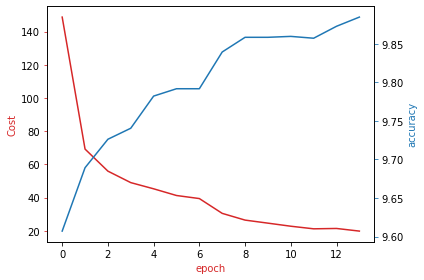

In [13]:
#Printing the data
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

In [14]:
def prediction(data_loader):
    test_pred = torch.LongTensor()
    for i, data in enumerate(data_loader):
        data = Variable(data, volatile=True)
        if torch.cuda.is_available():
            data = data.cuda()
        output = model(data)
        pred = output.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
    return test_pred

In [15]:
test_pred=prediction(test_loader)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.


In [16]:
test_dataset=PreProcess(raw_test,transform=transforms.Compose([transforms.ToPILImage(),transforms.ToTensor(),transforms.Normalize(mean=(0.5,),std=(0.5,))]))
result_df=pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1)[:,None], test_pred.numpy()],columns=['ImageId', 'Label'])

In [17]:
result_df.to_csv('Submission2.csv',index=False)
result_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
